In [1]:
import os
import glob
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

PyTorch: 2.8.0+cu126
CUDA: True
GPU: Tesla T4
GPU Memory: 15.8 GB


In [2]:
BASE_PATH = "/kaggle/input/pixel-play-26"
DATA_ROOT = os.path.join(BASE_PATH, os.listdir(BASE_PATH)[0])
AVENUE_PATH = os.path.join(DATA_ROOT, "Avenue_Corrupted", "Dataset")

TRAIN_VIDEOS = os.path.join(AVENUE_PATH, "training_videos")
TEST_VIDEOS = os.path.join(AVENUE_PATH, "testing_videos")
OUTPUT_DIR = "/kaggle/working"

print(f"TRAIN: {TRAIN_VIDEOS}")
print(f"TEST: {TEST_VIDEOS}")
print(f"Paths exist: Train={os.path.exists(TRAIN_VIDEOS)}, Test={os.path.exists(TEST_VIDEOS)}")

TRAIN: /kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/training_videos
TEST: /kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/testing_videos
Paths exist: Train=True, Test=True


In [3]:
CONFIG = {
    'image_size': (128, 128),
    'latent_dim': 256,
    'batch_size': 64,      # Can use larger batch with pre-loaded data
    'num_epochs': 20,
    'learning_rate': 1e-3,
    'seed': 42,
    'preload_to_gpu': True,  # Set False if GPU memory is limited
}

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])

print(f"Device: {DEVICE}")

Device: cuda


In [4]:
def discover_frames(video_dir):
    frames = defaultdict(list)
    if not os.path.exists(video_dir):
        return frames
    
    for vf in sorted(glob.glob(os.path.join(video_dir, '*'))):
        if not os.path.isdir(vf):
            continue
        try:
            vid = int(os.path.basename(vf))
        except:
            continue
        
        for ff in sorted(glob.glob(os.path.join(vf, '*.jpg'))):
            fname = os.path.basename(ff)
            fname_no_ext = os.path.splitext(fname)[0]
            
            # Handle "frame_XXXXX" format
            if fname_no_ext.startswith('frame_'):
                fname_no_ext = fname_no_ext.replace('frame_', '')
            
            try:
                fnum = int(fname_no_ext)
                frames[vid].append((fnum, ff))
            except:
                continue
        
        frames[vid].sort(key=lambda x: x[0])
    
    return dict(frames)

In [5]:
train_frames = discover_frames(TRAIN_VIDEOS)
test_frames = discover_frames(TEST_VIDEOS)

total_train = sum(len(v) for v in train_frames.values())
total_test = sum(len(v) for v in test_frames.values())

print(f"Train: {len(train_frames)} videos, {total_train} frames")
print(f"Test: {len(test_frames)} videos, {total_test} frames")

Train: 16 videos, 9204 frames
Test: 21 videos, 11706 frames


In [6]:
test_frame_ids = []
test_frame_info = []  # (vid, fnum) tuples for later reference

for vid in sorted(test_frames.keys()):
    for fnum, path in test_frames[vid]:
        test_frame_ids.append(f"{vid}_{fnum}")
        test_frame_info.append((vid, fnum))

print(f"Test frame IDs: {len(test_frame_ids)}")
print(f"First 5: {test_frame_ids[:5]}")

Test frame IDs: 11706
First 5: ['1_939', '1_940', '1_941', '1_942', '1_943']


In [7]:
def load_frames_to_tensor(frames_dict, image_size, desc="Loading"):
    """
    Load all frames into a single tensor.
    Returns: tensor of shape (N, 3, H, W), list of (vid, fnum) tuples
    """
    # Count total frames
    total = sum(len(v) for v in frames_dict.values())
    
    # Pre-allocate tensor (much faster than appending)
    H, W = image_size
    all_frames = torch.zeros(total, 3, H, W, dtype=torch.float32)
    frame_info = []
    
    idx = 0
    pbar = tqdm(total=total, desc=desc)
    
    for vid in sorted(frames_dict.keys()):
        for fnum, path in frames_dict[vid]:
            # Load image
            img = Image.open(path).convert('RGB')
            img = img.resize((W, H), Image.BILINEAR)
            
            # Convert to tensor and normalize to [-1, 1]
            img_tensor = torch.from_numpy(np.array(img)).permute(2, 0, 1).float()
            img_tensor = img_tensor / 127.5 - 1.0  # [0,255] -> [-1,1]
            
            all_frames[idx] = img_tensor
            frame_info.append((vid, fnum))
            idx += 1
            pbar.update(1)
    
    pbar.close()
    return all_frames, frame_info

In [8]:
print("Loading training frames into memory...")
train_tensors, train_info = load_frames_to_tensor(
    train_frames, 
    CONFIG['image_size'],
    desc="Loading train"
)

print(f"\nTrain tensor shape: {train_tensors.shape}")
print(f"Train tensor dtype: {train_tensors.dtype}")
print(f"Train tensor range: [{train_tensors.min():.2f}, {train_tensors.max():.2f}]")
print(f"Memory: {train_tensors.element_size() * train_tensors.numel() / 1e9:.2f} GB")

Loading training frames into memory...


Loading train: 100%|██████████| 9204/9204 [01:14<00:00, 124.09it/s]



Train tensor shape: torch.Size([9204, 3, 128, 128])
Train tensor dtype: torch.float32
Train tensor range: [-1.00, 1.00]
Memory: 1.81 GB


In [9]:
print("Loading testing frames into memory...")
test_tensors, test_info = load_frames_to_tensor(
    test_frames,
    CONFIG['image_size'],
    desc="Loading test"
)

print(f"\nTest tensor shape: {test_tensors.shape}")
print(f"Memory: {test_tensors.element_size() * test_tensors.numel() / 1e9:.2f} GB")

# Verify test_info matches test_frame_info
assert test_info == test_frame_info, "Frame order mismatch!"
print("\n✓ Frame order verified!")

Loading testing frames into memory...


Loading test: 100%|██████████| 11706/11706 [01:35<00:00, 122.03it/s]


Test tensor shape: torch.Size([11706, 3, 128, 128])
Memory: 2.30 GB

✓ Frame order verified!


In [10]:
if CONFIG['preload_to_gpu'] and DEVICE == 'cuda':
    print("Moving tensors to GPU...")
    train_tensors = train_tensors.to(DEVICE)
    test_tensors = test_tensors.to(DEVICE)
    print(f"GPU Memory used: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
else:
    print("Keeping tensors on CPU (will transfer batches during training)")

Moving tensors to GPU...
GPU Memory used: 4.11 GB


In [11]:
class PreloadedDataset(Dataset):
    """Dataset that wraps pre-loaded tensors. Super fast!"""
    
    def __init__(self, tensors, frame_info=None):
        self.tensors = tensors
        self.frame_info = frame_info
    
    def __len__(self):
        return len(self.tensors)
    
    def __getitem__(self, idx):
        if self.frame_info is not None:
            vid, fnum = self.frame_info[idx]
            return self.tensors[idx], vid, fnum
        return self.tensors[idx]

train_dataset = PreloadedDataset(train_tensors)
test_dataset = PreloadedDataset(test_tensors, test_info)

print(f"Train dataset: {len(train_dataset)} frames")
print(f"Test dataset: {len(test_dataset)} frames")

Train dataset: 9204 frames
Test dataset: 11706 frames


In [12]:
# Note: pin_memory=False since data may already be on GPU
# num_workers=0 since we're not doing disk I/O

train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=0,
    pin_memory=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 144
Test batches: 183


In [13]:
import time

# Warm up
_ = next(iter(train_loader))

# Time 10 iterations
start = time.time()
for i, batch in enumerate(train_loader):
    if i >= 10:
        break
    if not CONFIG['preload_to_gpu']:
        batch = batch.to(DEVICE)
elapsed = time.time() - start

print(f"10 batches loaded in {elapsed:.3f}s")
print(f"Average: {elapsed/10*1000:.1f}ms per batch")
print("\n✓ This should be MUCH faster than PIL loading!")

10 batches loaded in 0.004s
Average: 0.4ms per batch

✓ This should be MUCH faster than PIL loading!


In [14]:
class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.LeakyReLU(0.2),
        )
        
        self.fc_enc = nn.Linear(512*4*4, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, 512*4*4)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Tanh(),
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        z = self.fc_enc(x)
        x = self.fc_dec(z)
        x = x.view(-1, 512, 4, 4)
        return self.decoder(x)

model = ConvAutoencoder(CONFIG['latent_dim']).to(DEVICE)
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

Parameters: 9,780,803


In [15]:
with torch.no_grad():
    x = torch.randn(2, 3, 128, 128).to(DEVICE)
    y = model(x)
print(f"Input: {x.shape} -> Output: {y.shape}")
print("✓ Model OK")

Input: torch.Size([2, 3, 128, 128]) -> Output: torch.Size([2, 3, 128, 128])
✓ Model OK


In [16]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG['num_epochs'])

In [17]:
print("="*50)
print("Starting Training (Optimized)")
print("="*50)

history = {'loss': [], 'time': []}

for epoch in range(CONFIG['num_epochs']):
    model.train()
    total_loss = 0
    epoch_start = time.time()
    
    for batch in train_loader:
        # Data is already on GPU if preload_to_gpu=True
        if isinstance(batch, tuple):
            frames = batch[0]
        else:
            frames = batch
        
        if not CONFIG['preload_to_gpu']:
            frames = frames.to(DEVICE)
        
        optimizer.zero_grad()
        recon = model(frames)
        loss = criterion(recon, frames)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    scheduler.step()
    
    epoch_time = time.time() - epoch_start
    avg_loss = total_loss / len(train_loader)
    history['loss'].append(avg_loss)
    history['time'].append(epoch_time)
    
    print(f"Epoch {epoch+1:02d}/{CONFIG['num_epochs']} | "
          f"Loss: {avg_loss:.6f} | "
          f"Time: {epoch_time:.1f}s | "
          f"LR: {scheduler.get_last_lr()[0]:.6f}")

total_time = sum(history['time'])
print(f"\nTotal training time: {total_time:.1f}s ({total_time/60:.1f} min)")
print(f"Average epoch time: {total_time/CONFIG['num_epochs']:.1f}s")

Starting Training (Optimized)
Epoch 01/20 | Loss: 0.047603 | Time: 8.4s | LR: 0.000994
Epoch 02/20 | Loss: 0.012950 | Time: 8.1s | LR: 0.000976
Epoch 03/20 | Loss: 0.008995 | Time: 8.2s | LR: 0.000946
Epoch 04/20 | Loss: 0.006795 | Time: 8.3s | LR: 0.000905
Epoch 05/20 | Loss: 0.005716 | Time: 8.5s | LR: 0.000854
Epoch 06/20 | Loss: 0.005223 | Time: 8.6s | LR: 0.000794
Epoch 07/20 | Loss: 0.004434 | Time: 8.7s | LR: 0.000727
Epoch 08/20 | Loss: 0.004308 | Time: 8.8s | LR: 0.000655
Epoch 09/20 | Loss: 0.004135 | Time: 8.9s | LR: 0.000578
Epoch 10/20 | Loss: 0.003520 | Time: 9.0s | LR: 0.000500
Epoch 11/20 | Loss: 0.003329 | Time: 9.1s | LR: 0.000422
Epoch 12/20 | Loss: 0.003142 | Time: 9.2s | LR: 0.000345
Epoch 13/20 | Loss: 0.002948 | Time: 9.0s | LR: 0.000273
Epoch 14/20 | Loss: 0.002713 | Time: 8.9s | LR: 0.000206
Epoch 15/20 | Loss: 0.002594 | Time: 8.9s | LR: 0.000146
Epoch 16/20 | Loss: 0.002411 | Time: 8.9s | LR: 0.000095
Epoch 17/20 | Loss: 0.002284 | Time: 8.9s | LR: 0.000054
E

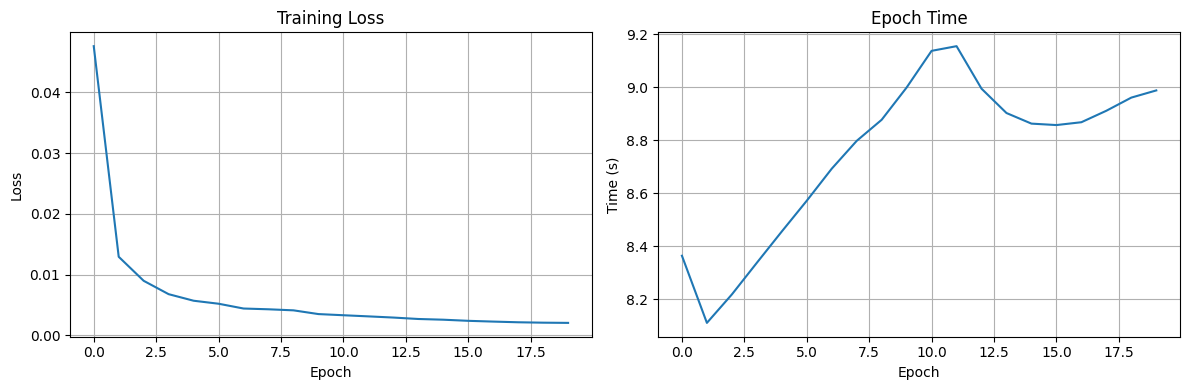

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history['loss'])
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].grid(True)

axes[1].plot(history['time'])
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Time (s)')
axes[1].set_title('Epoch Time')
axes[1].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'training.png'))
plt.show()

In [19]:
def compute_scores_fast(model, test_tensors, test_info, batch_size=128):
    """Compute all scores efficiently using large batches."""
    model.eval()
    scores = {}
    
    n = len(test_tensors)
    
    with torch.no_grad():
        for start in tqdm(range(0, n, batch_size), desc="Scoring"):
            end = min(start + batch_size, n)
            
            batch = test_tensors[start:end]
            if not CONFIG['preload_to_gpu']:
                batch = batch.to(DEVICE)
            
            recon = model(batch)
            mse = torch.mean((batch - recon)**2, dim=(1, 2, 3))
            
            for i, score in enumerate(mse.cpu().numpy()):
                vid, fnum = test_info[start + i]
                scores[f"{vid}_{fnum}"] = float(score)
    
    return scores

anomaly_scores = compute_scores_fast(model, test_tensors, test_info)
print(f"Computed {len(anomaly_scores)} scores")

Scoring: 100%|██████████| 92/92 [00:04<00:00, 21.24it/s]

Computed 11706 scores


In [20]:
expected = set(test_frame_ids)
computed = set(anomaly_scores.keys())

print(f"Expected: {len(expected)}")
print(f"Computed: {len(computed)}")
print(f"Missing: {len(expected - computed)}")

if expected == computed:
    print("\nPerfect match!")
else:
    print("\nMISMATCH!")
    print(f"Missing: {list(expected - computed)[:5]}")
    

Expected: 11706
Computed: 11706
Missing: 0

Perfect match!


In [21]:
scores_arr = np.array(list(anomaly_scores.values()))
print(f"Min: {scores_arr.min():.6f}")
print(f"Max: {scores_arr.max():.6f}")
print(f"Mean: {scores_arr.mean():.6f}")
print(f"Std: {scores_arr.std():.6f}")

Min: 0.001928
Max: 0.459740
Mean: 0.055946
Std: 0.126791


In [22]:
def normalize(scores):
    vals = np.array(list(scores.values()))
    keys = list(scores.keys())
    min_v, max_v = vals.min(), vals.max()
    norm = (vals - min_v) / (max_v - min_v + 1e-8)
    return {k: norm[i] for i, k in enumerate(keys)}

normalized_scores = normalize(anomaly_scores)
print(f"Normalized range: [0, 1]")

Normalized range: [0, 1]


In [23]:
def create_submission(scores, expected_ids, path):
    data = [{'Id': fid, 'Predicted': scores.get(fid, 0.0)} for fid in expected_ids]
    df = pd.DataFrame(data)
    df.to_csv(path, index=False)
    print(f"Saved: {path}")
    print(f"  Rows: {len(df)}")
    print(f"  Range: [{df['Predicted'].min():.4f}, {df['Predicted'].max():.4f}]")
    return df

submission_path = os.path.join(OUTPUT_DIR, 'submission.csv')
submission_df = create_submission(normalized_scores, test_frame_ids, submission_path)

Saved: /kaggle/working/submission.csv
  Rows: 11706
  Range: [0.0000, 1.0000]


In [24]:
print("First 10 rows:")
print(submission_df.head(10))
print("\nLast 10 rows:")  
print(submission_df.tail(10))

First 10 rows:
      Id  Predicted
0  1_939   0.161224
1  1_940   0.192335
2  1_941   0.218245
3  1_942   0.212271
4  1_943   0.179240
5  1_944   0.791959
6  1_945   0.109811
7  1_946   0.139228
8  1_947   0.194686
9  1_948   0.210786

Last 10 rows:
          Id  Predicted
11696  21_66   0.037983
11697  21_67   0.031342
11698  21_68   0.029640
11699  21_69   0.029039
11700  21_70   0.029541
11701  21_71   0.935574
11702  21_72   0.030343
11703  21_73   0.030069
11704  21_74   0.030528
11705  21_75   0.031230


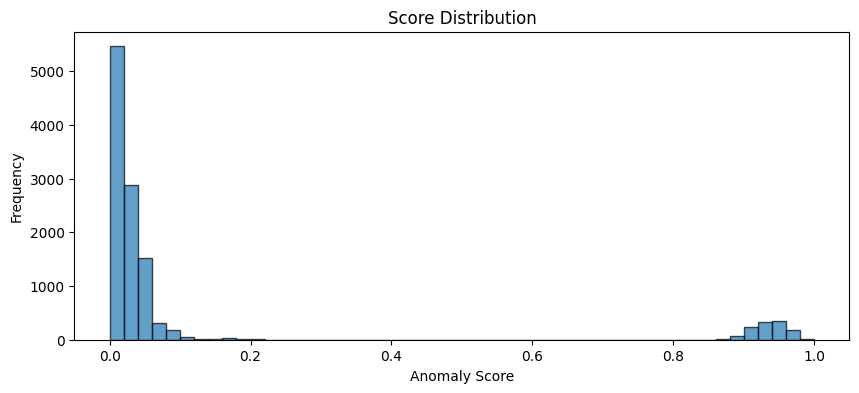

In [25]:
plt.figure(figsize=(10, 4))
plt.hist(list(normalized_scores.values()), bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Score Distribution')
plt.savefig(os.path.join(OUTPUT_DIR, 'score_dist.png'))
plt.show()

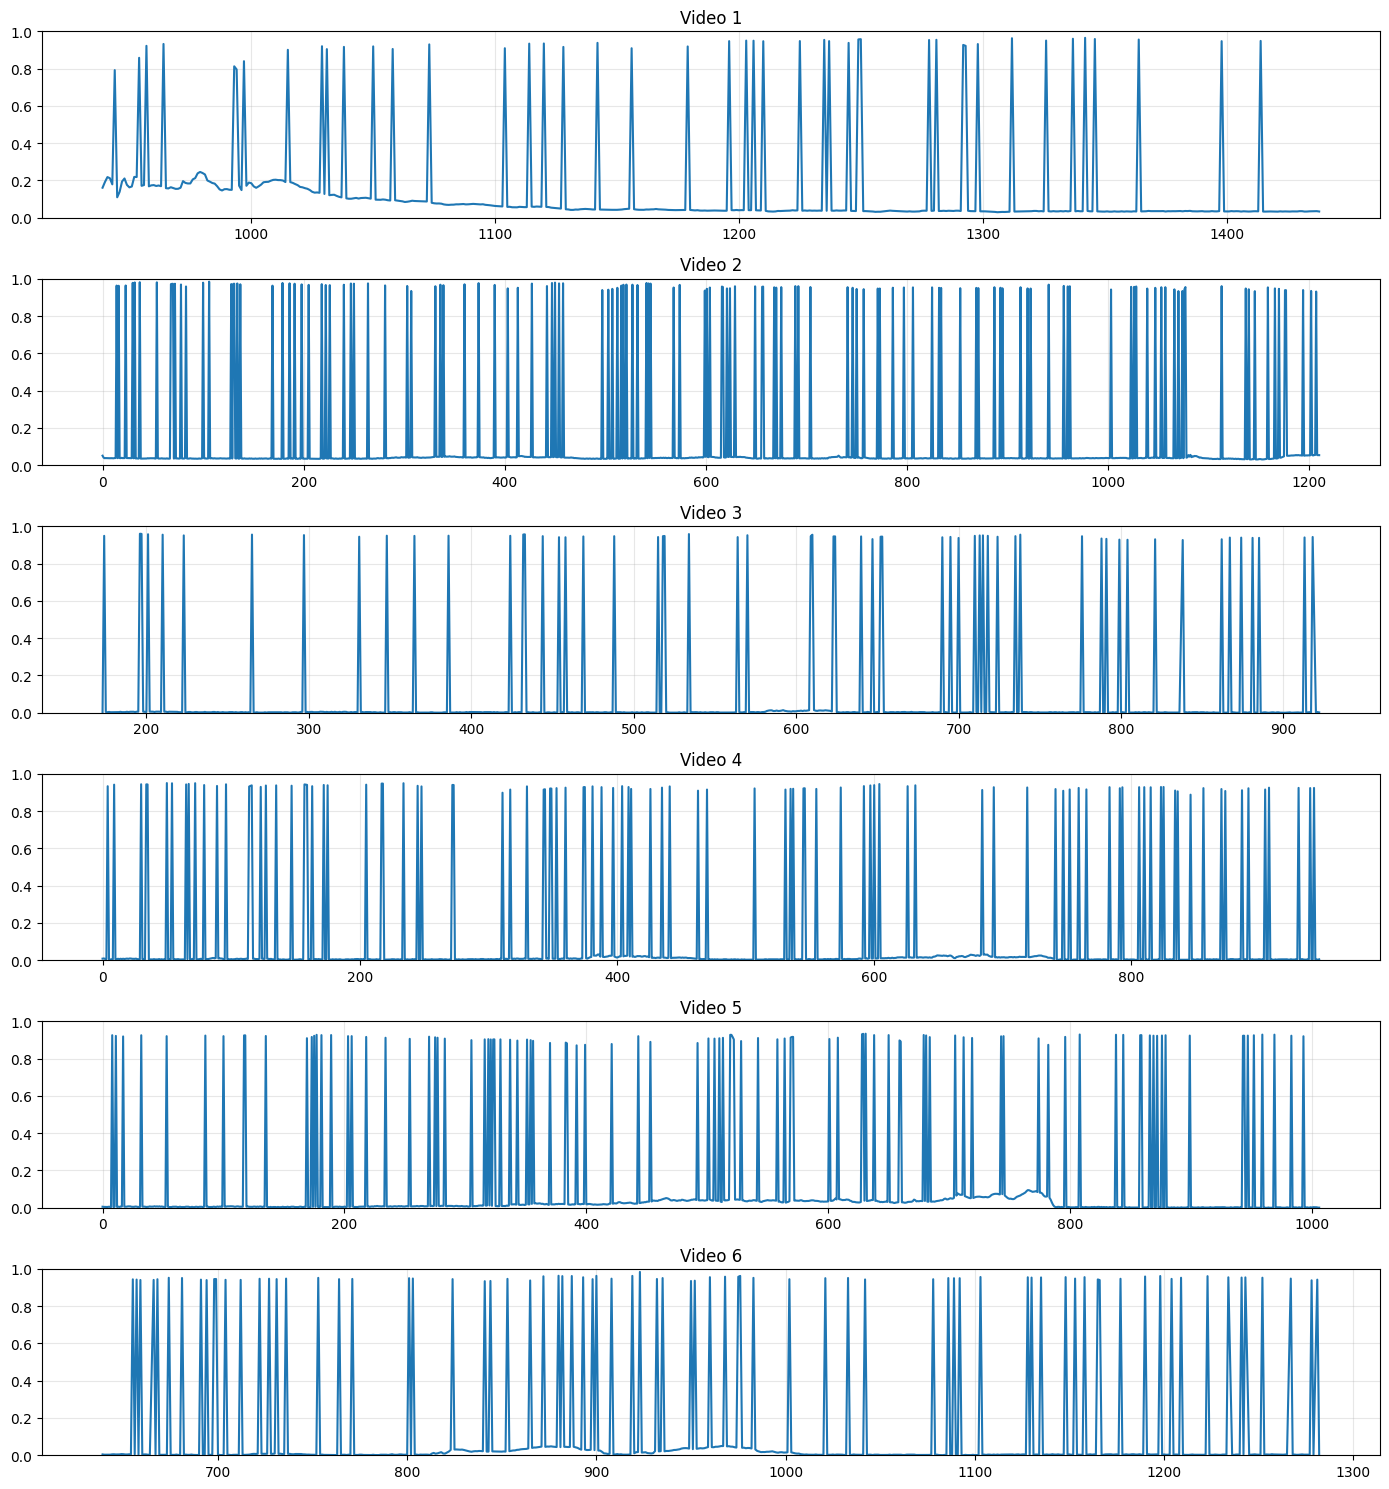

In [26]:
num_vids = len(test_frames)
fig, axes = plt.subplots(min(num_vids, 6), 1, figsize=(14, 2.5*min(num_vids, 6)))
if num_vids == 1:
    axes = [axes]

for idx, vid in enumerate(sorted(test_frames.keys())[:6]):
    fnums = [f[0] for f in test_frames[vid]]
    scores = [normalized_scores.get(f"{vid}_{fn}", 0) for fn in fnums]
    
    axes[idx].plot(fnums, scores)
    axes[idx].set_title(f'Video {vid}')
    axes[idx].set_ylim(0, 1)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'temporal.png'))
plt.show()

In [27]:
# Free GPU memory if needed
if CONFIG['preload_to_gpu']:
    del train_tensors
    del test_tensors
    torch.cuda.empty_cache()
    print("GPU memory freed")
    print(f"GPU Memory now: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

GPU memory freed
GPU Memory now: 4.33 GB
